In [1]:
import tarfile
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, ema_logging,Policy)

from ema_workbench import Samplers

from ema_workbench import load_results

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

import copy

In [2]:
#results = load_results("results/dike_model_test_sobol_do_nothing.tar.gz")
results = load_results("results/dike_model_test_sobol_4_policies.tar.gz")
#results = load_results("results/dike_model_test_sobol_policies_example_policies.tar.gz")
experiments, outcomes = results

In [3]:
# observing the simulation runs
experiments, outcomes = results
print(outcomes.keys())
experiments.head()


dict_keys(['A.1_Expected Annual Damage', 'A.1_Dike Investment Costs', 'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage', 'A.2_Dike Investment Costs', 'A.2_Expected Number of Deaths', 'A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths', 'A.4_Expected Annual Damage', 'A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths', 'A.5_Expected Annual Damage', 'A.5_Dike Investment Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,57,287.43786,1.5,0.772591,134.812098,1.0,0.671951,231.294401,1.5,0.044211,...,6,10,3,9,2,1,1,4,0,dikesnet
1,41,287.43786,1.5,0.772591,134.812098,1.0,0.671951,231.294401,1.5,0.044211,...,6,10,3,9,2,1,1,5,0,dikesnet
2,57,273.08601,1.5,0.772591,134.812098,1.0,0.671951,231.294401,1.5,0.044211,...,6,10,3,9,2,1,1,6,0,dikesnet
3,57,287.43786,1.0,0.772591,134.812098,1.0,0.671951,231.294401,1.5,0.044211,...,6,10,3,9,2,1,1,7,0,dikesnet
4,57,287.43786,1.5,0.153376,134.812098,1.0,0.671951,231.294401,1.5,0.044211,...,6,10,3,9,2,1,1,8,0,dikesnet


In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)
dike_model, planning_steps = get_model_for_problem_formulation(5)
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)


In [5]:
kpi_list=list(outcomes.keys())
ooi=kpi_list[5]
print(kpi_list)
print(ooi)

['A.1_Expected Annual Damage', 'A.1_Dike Investment Costs', 'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage', 'A.2_Dike Investment Costs', 'A.2_Expected Number of Deaths', 'A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths', 'A.4_Expected Annual Damage', 'A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths', 'A.5_Expected Annual Damage', 'A.5_Dike Investment Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
A.2_Expected Number of Deaths


## Grouping outcomes per dike ring

In [6]:
from collections import defaultdict
group = defaultdict(list)
tmp_key=kpi_list[0].split(sep='_')[0]
print(tmp_key)
for i in kpi_list:
    tmp=i.split(sep='_')[0]
    if tmp == tmp_key:
        group[tmp_key].append(i)
    else:
        tmp_key=tmp
        group[tmp_key].append(i)
        
    
    

A.1


In [7]:
dikerings=group.keys()
print(dikerings)

dict_keys(['A.1', 'A.2', 'A.3', 'A.4', 'A.5', 'RfR Total Costs', 'Expected Evacuation Costs'])


In [8]:
def analyze(results, kpi,planning_step):
    """analyze results using SALib sobol, returns a dataframe"""
    _, outcomes = results
    
    problem = get_SALib_problem(dike_model.uncertainties)
    y = outcomes[kpi][:,planning_step]
    sobol_indices = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)
    sobol_stats = {key: sobol_indices[key] for key in ["ST", "ST_conf", "S1", "S1_conf"]}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem["names"])
    sobol_stats.sort_values(by="ST", ascending=False)
    s2 = pd.DataFrame(sobol_indices["S2"], index=problem["names"], columns=problem["names"])
    s2_conf = pd.DataFrame(sobol_indices["S2_conf"], index=problem["names"], columns=problem["names"])
    return sobol_stats, s2, s2_conf

In [9]:
outcomes['A.1_Dike Investment Costs'].nonzero()[0].size

46200

In [10]:
dikerings

dict_keys(['A.1', 'A.2', 'A.3', 'A.4', 'A.5', 'RfR Total Costs', 'Expected Evacuation Costs'])

In [11]:
sobol_data=defaultdict(dict)
s2_data= defaultdict(dict)
s2_data_conf=defaultdict(dict)

for k,v in group.items():
    sobol_data[k]=defaultdict(dict)
    s2_data[k]=defaultdict(dict)
    s2_data_conf[k]=defaultdict(dict)
    for ooi in v:
        sobol_data[k][ooi]=defaultdict(pd.DataFrame)
        s2_data[k][ooi]=defaultdict(dict)
        s2_data_conf[k][ooi]=defaultdict(dict)              
        for planning_step in range(0,3):
            if outcomes[ooi].nonzero()[0].size:
                sobol_stats, s2, s2_conf = analyze(results, ooi, planning_step)
                sobol_data[k][ooi][planning_step] = sobol_stats
                s2_data[k][ooi][planning_step] = s2
                s2_data_conf[k][ooi][planning_step]=s2_conf
            else: 
                del sobol_data[k][ooi]
                break

            
    

C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\SALib\analyze\sobol.py:141: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


In [12]:
#sobol_data['A.2'].keys()

In [13]:
#planning_step = 0
#sobol_stats, s2, s2_conf = analyze(results, ooi, planning_step)

In [14]:
#indices=sobol_data['A.1']['A.1_Expected Annual Damage'][0][['S1','ST']]
#err=sobol_data['A.1']['A.1_Expected Annual Damage'][0][['S1_conf','ST_conf']]
#indices.plot.bar(yerr=err.values.T)

In [15]:
#dike= 'A.1'
#sobol_data[step][dike].keys()


TypeError: 'Axes' object is not subscriptable

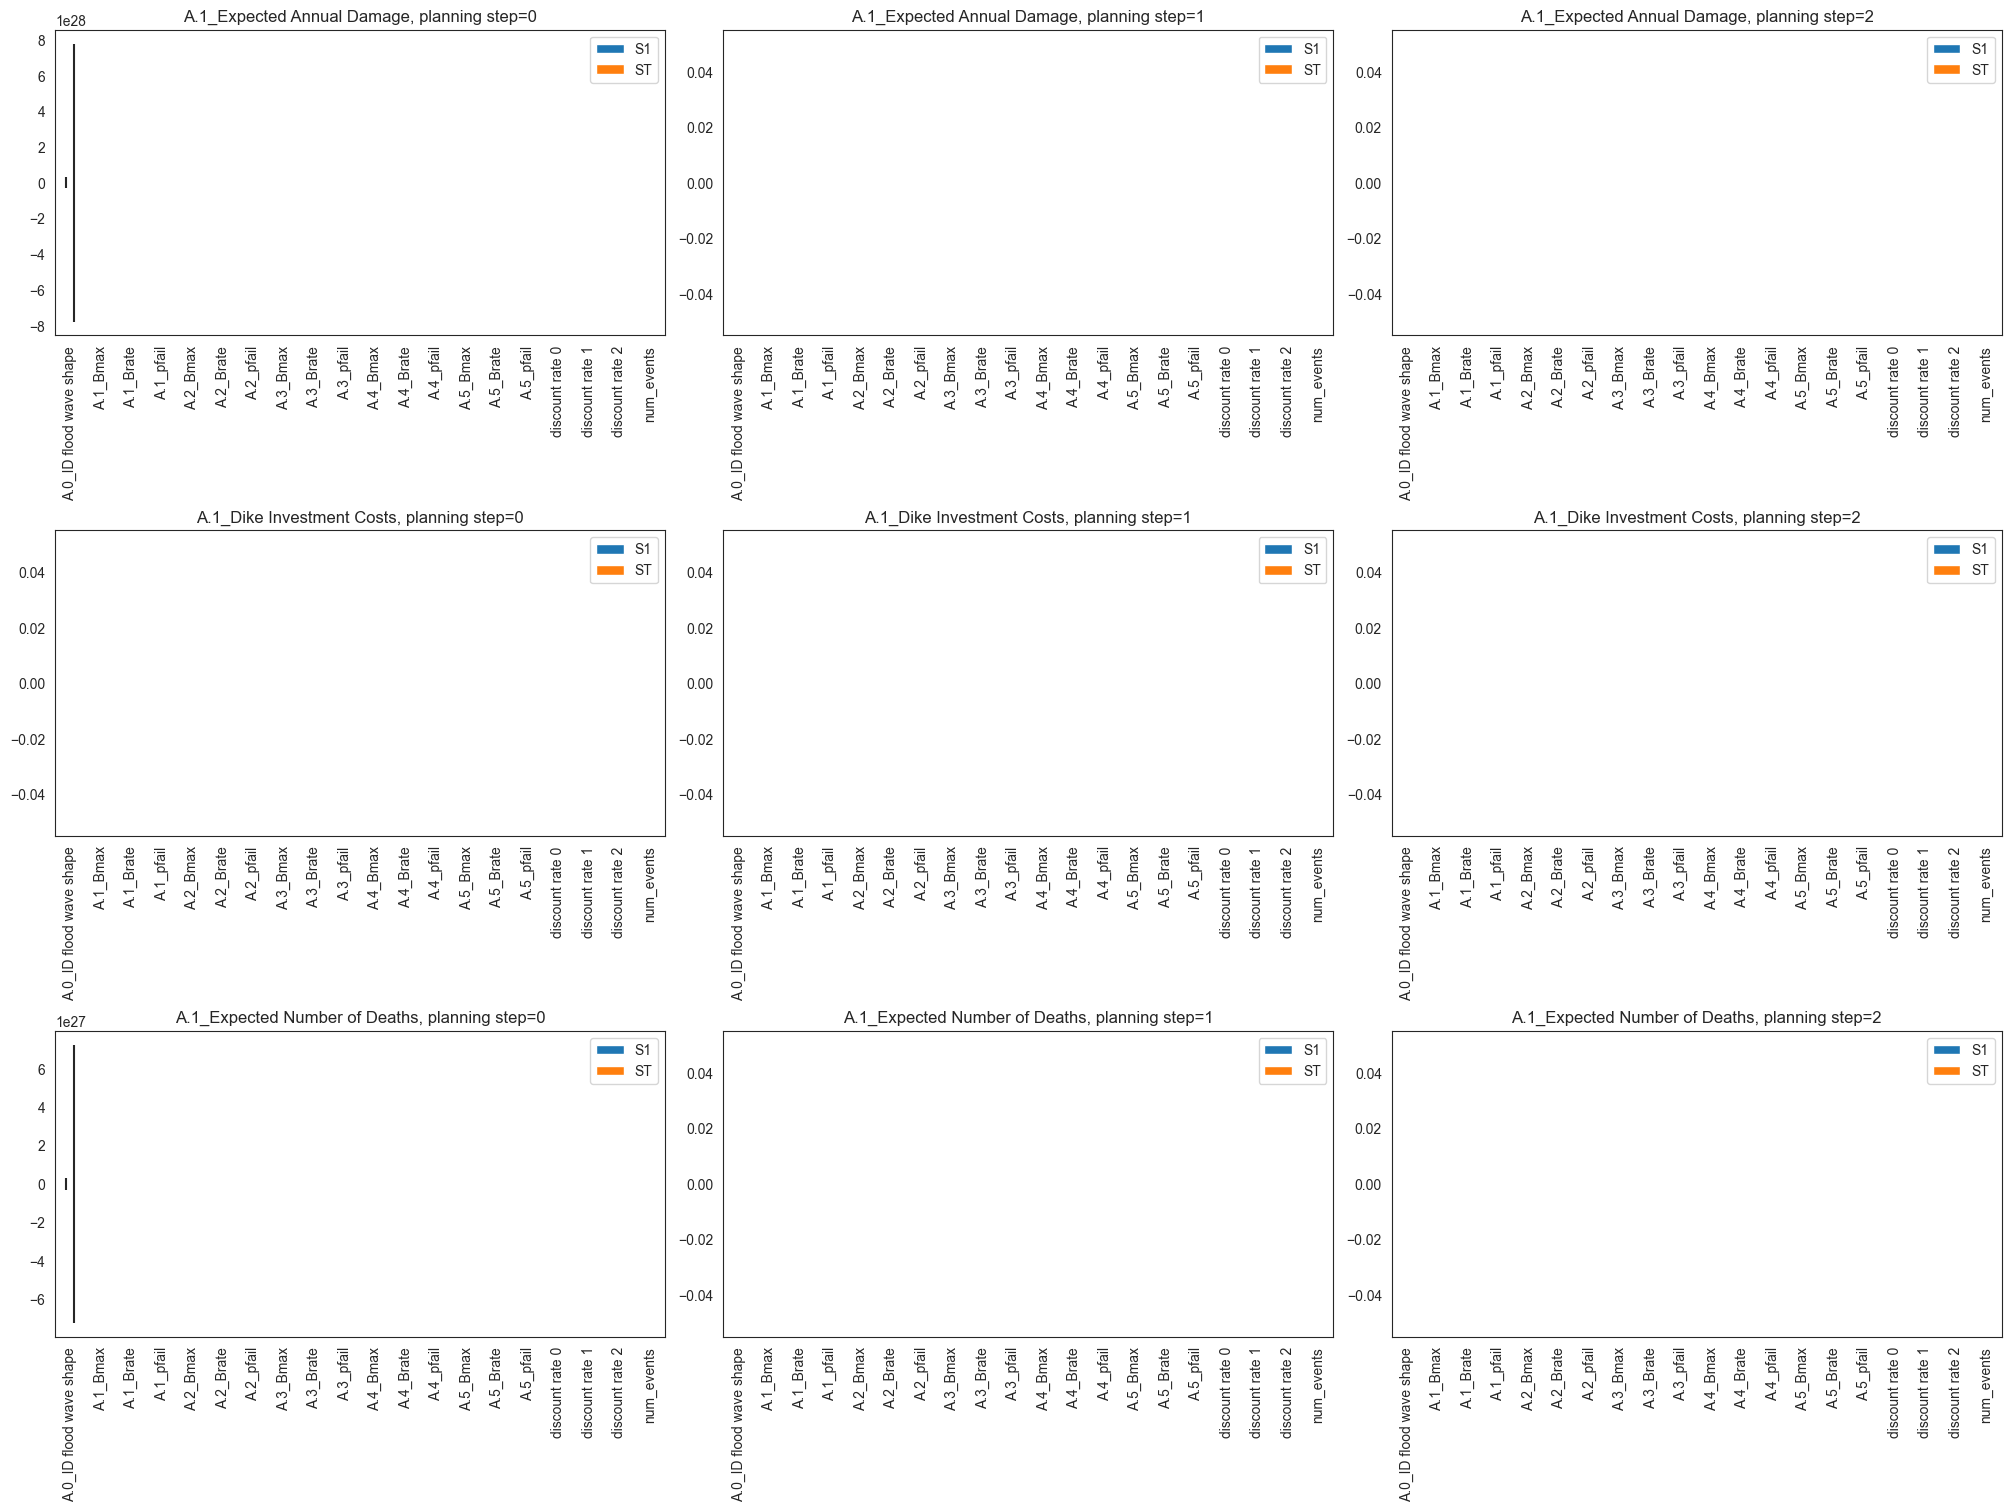

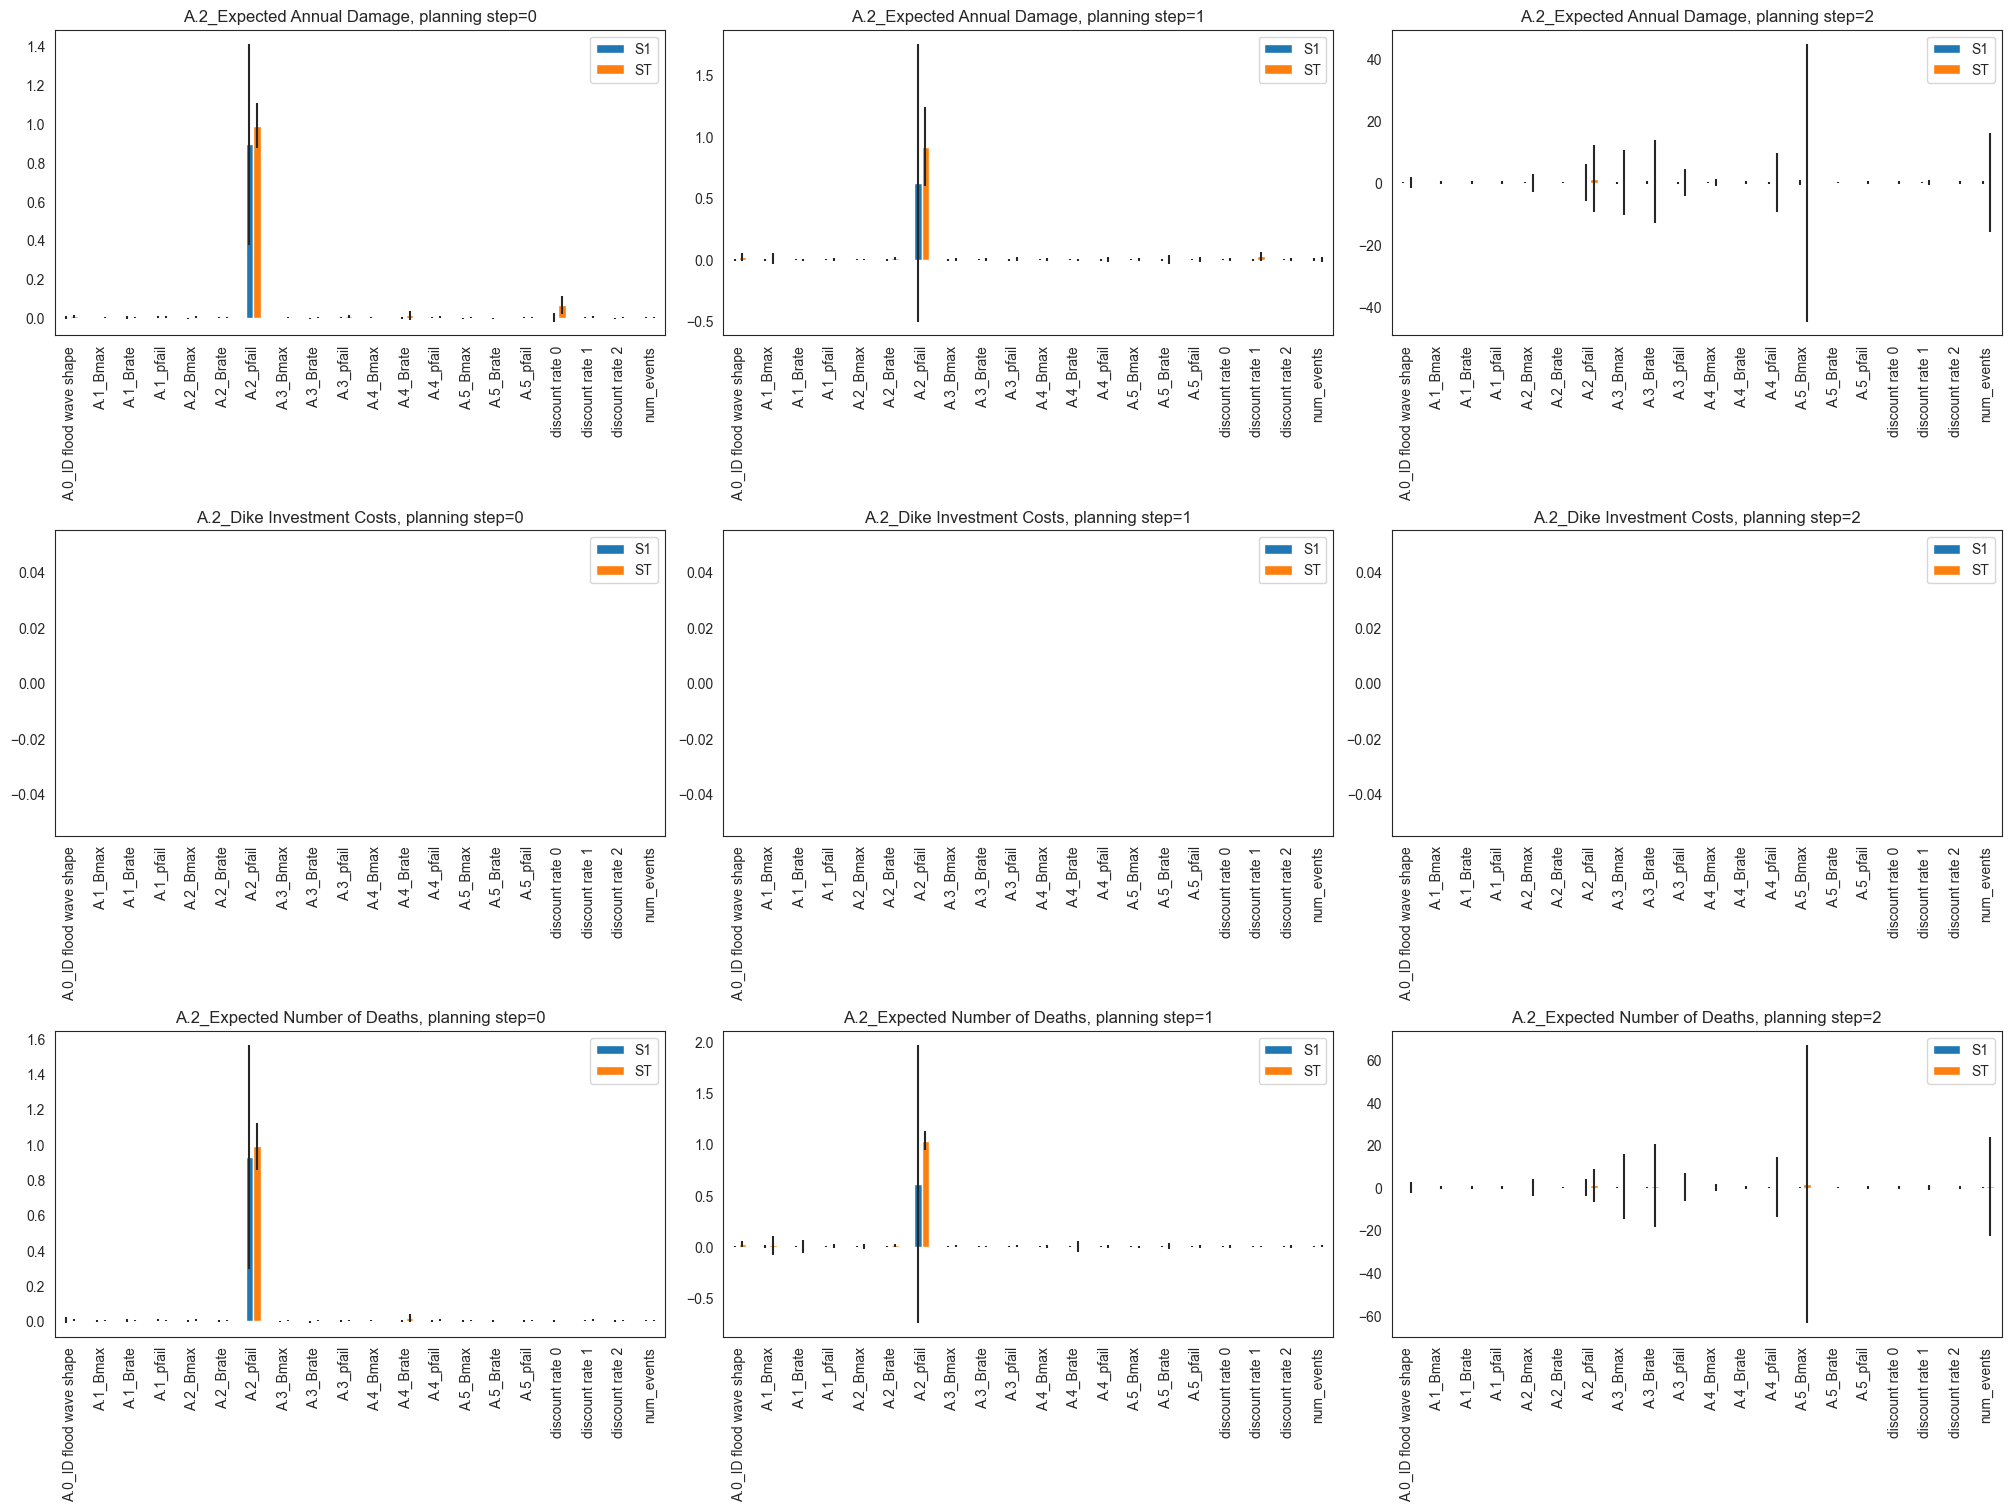

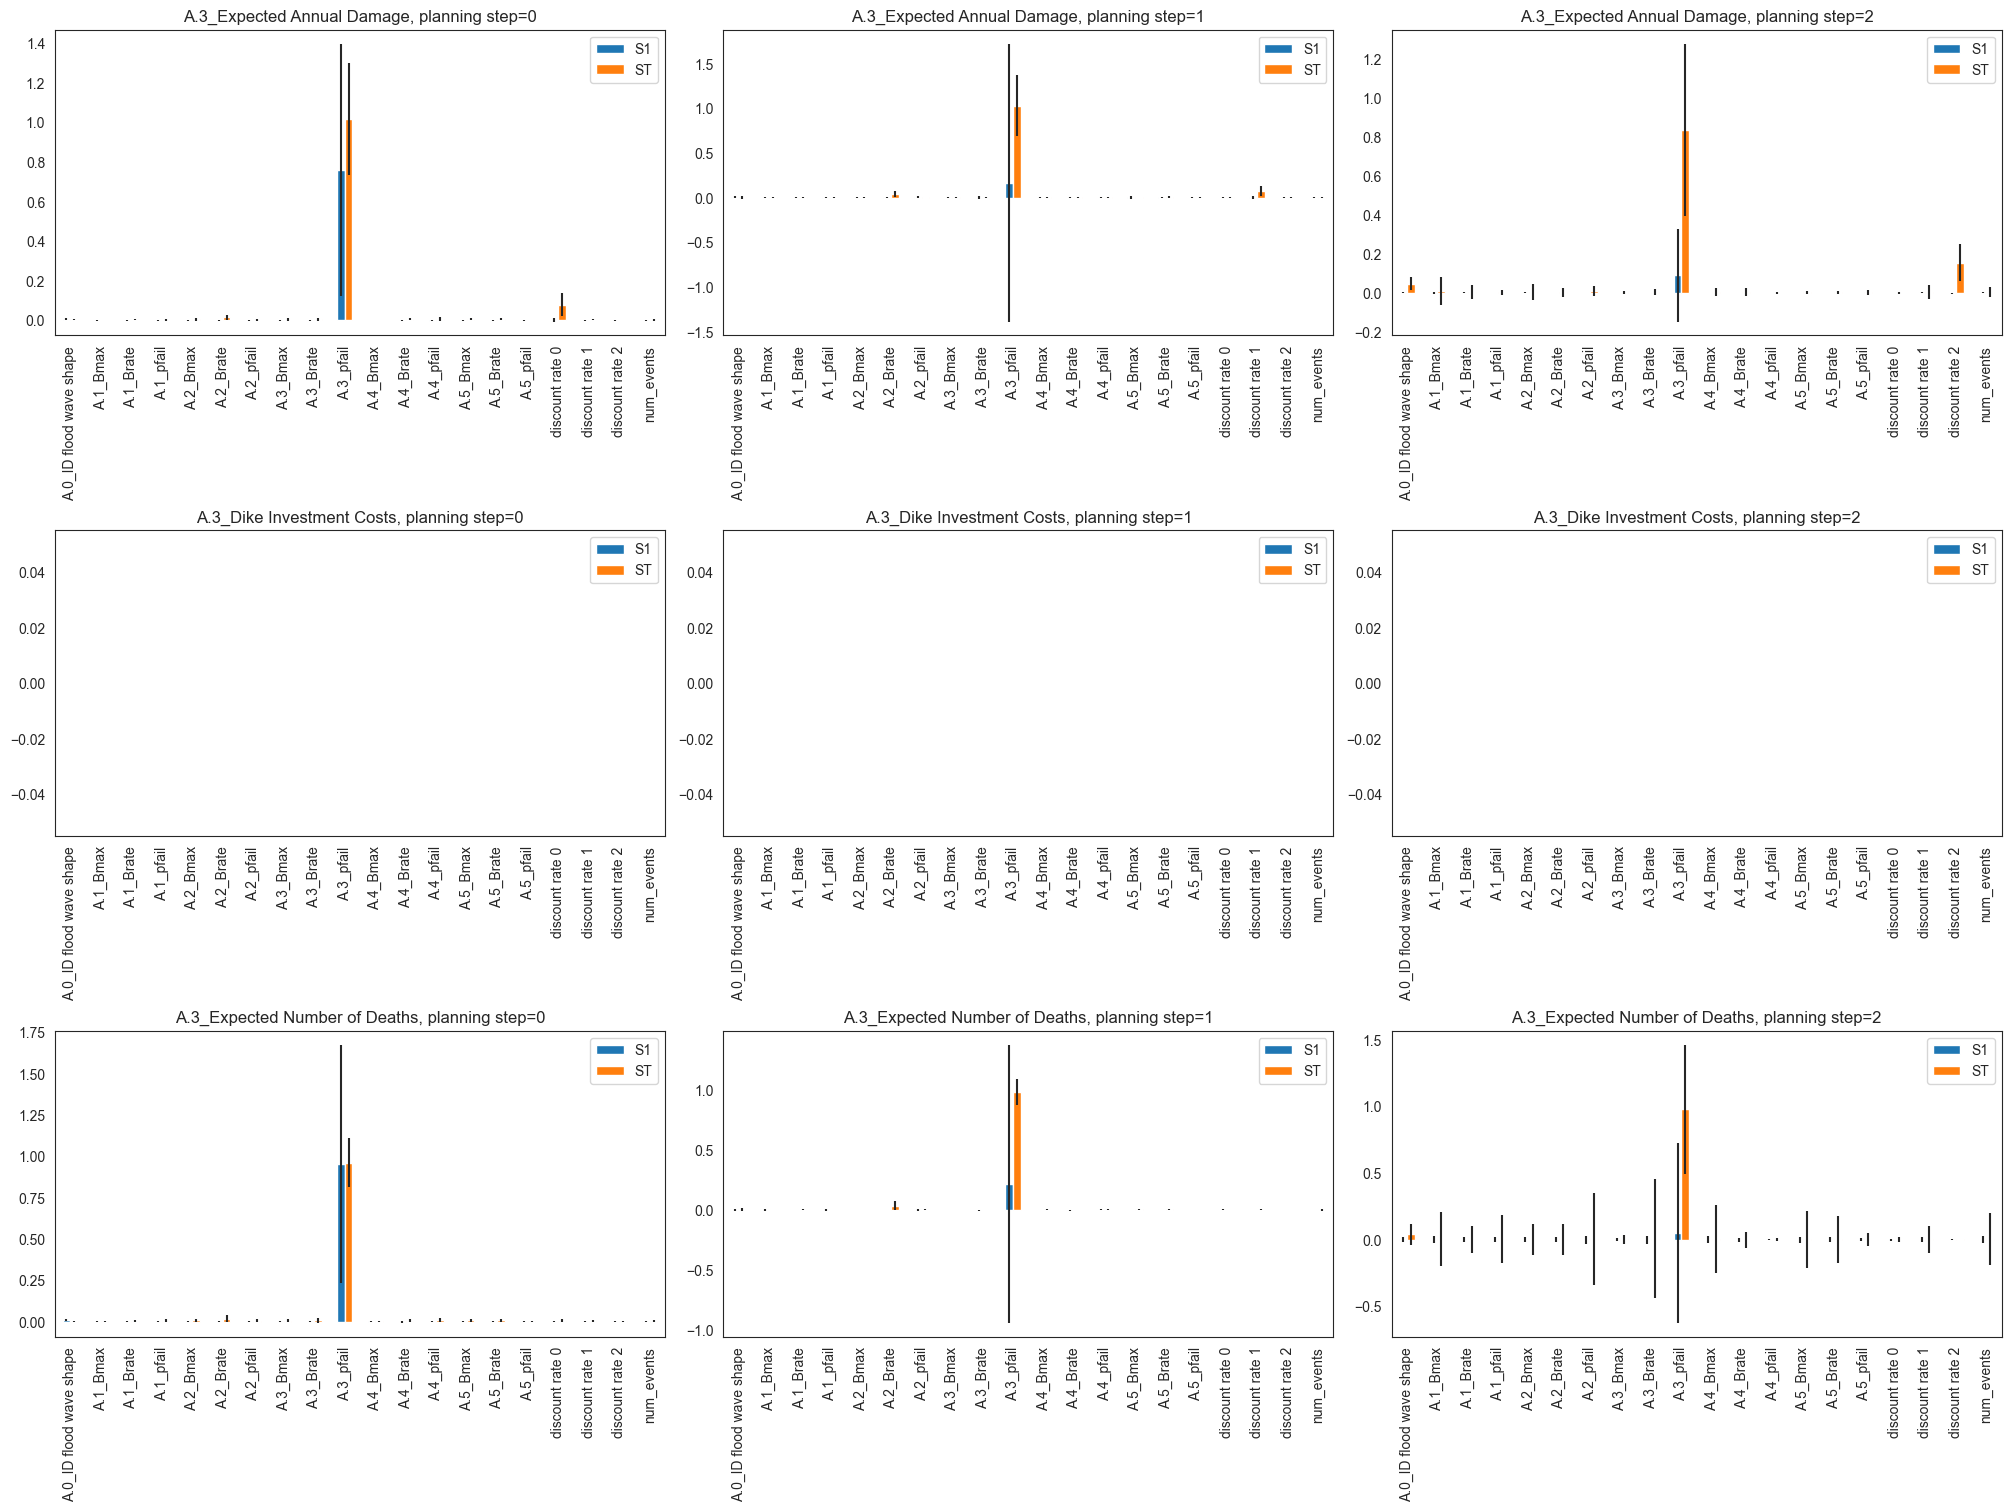

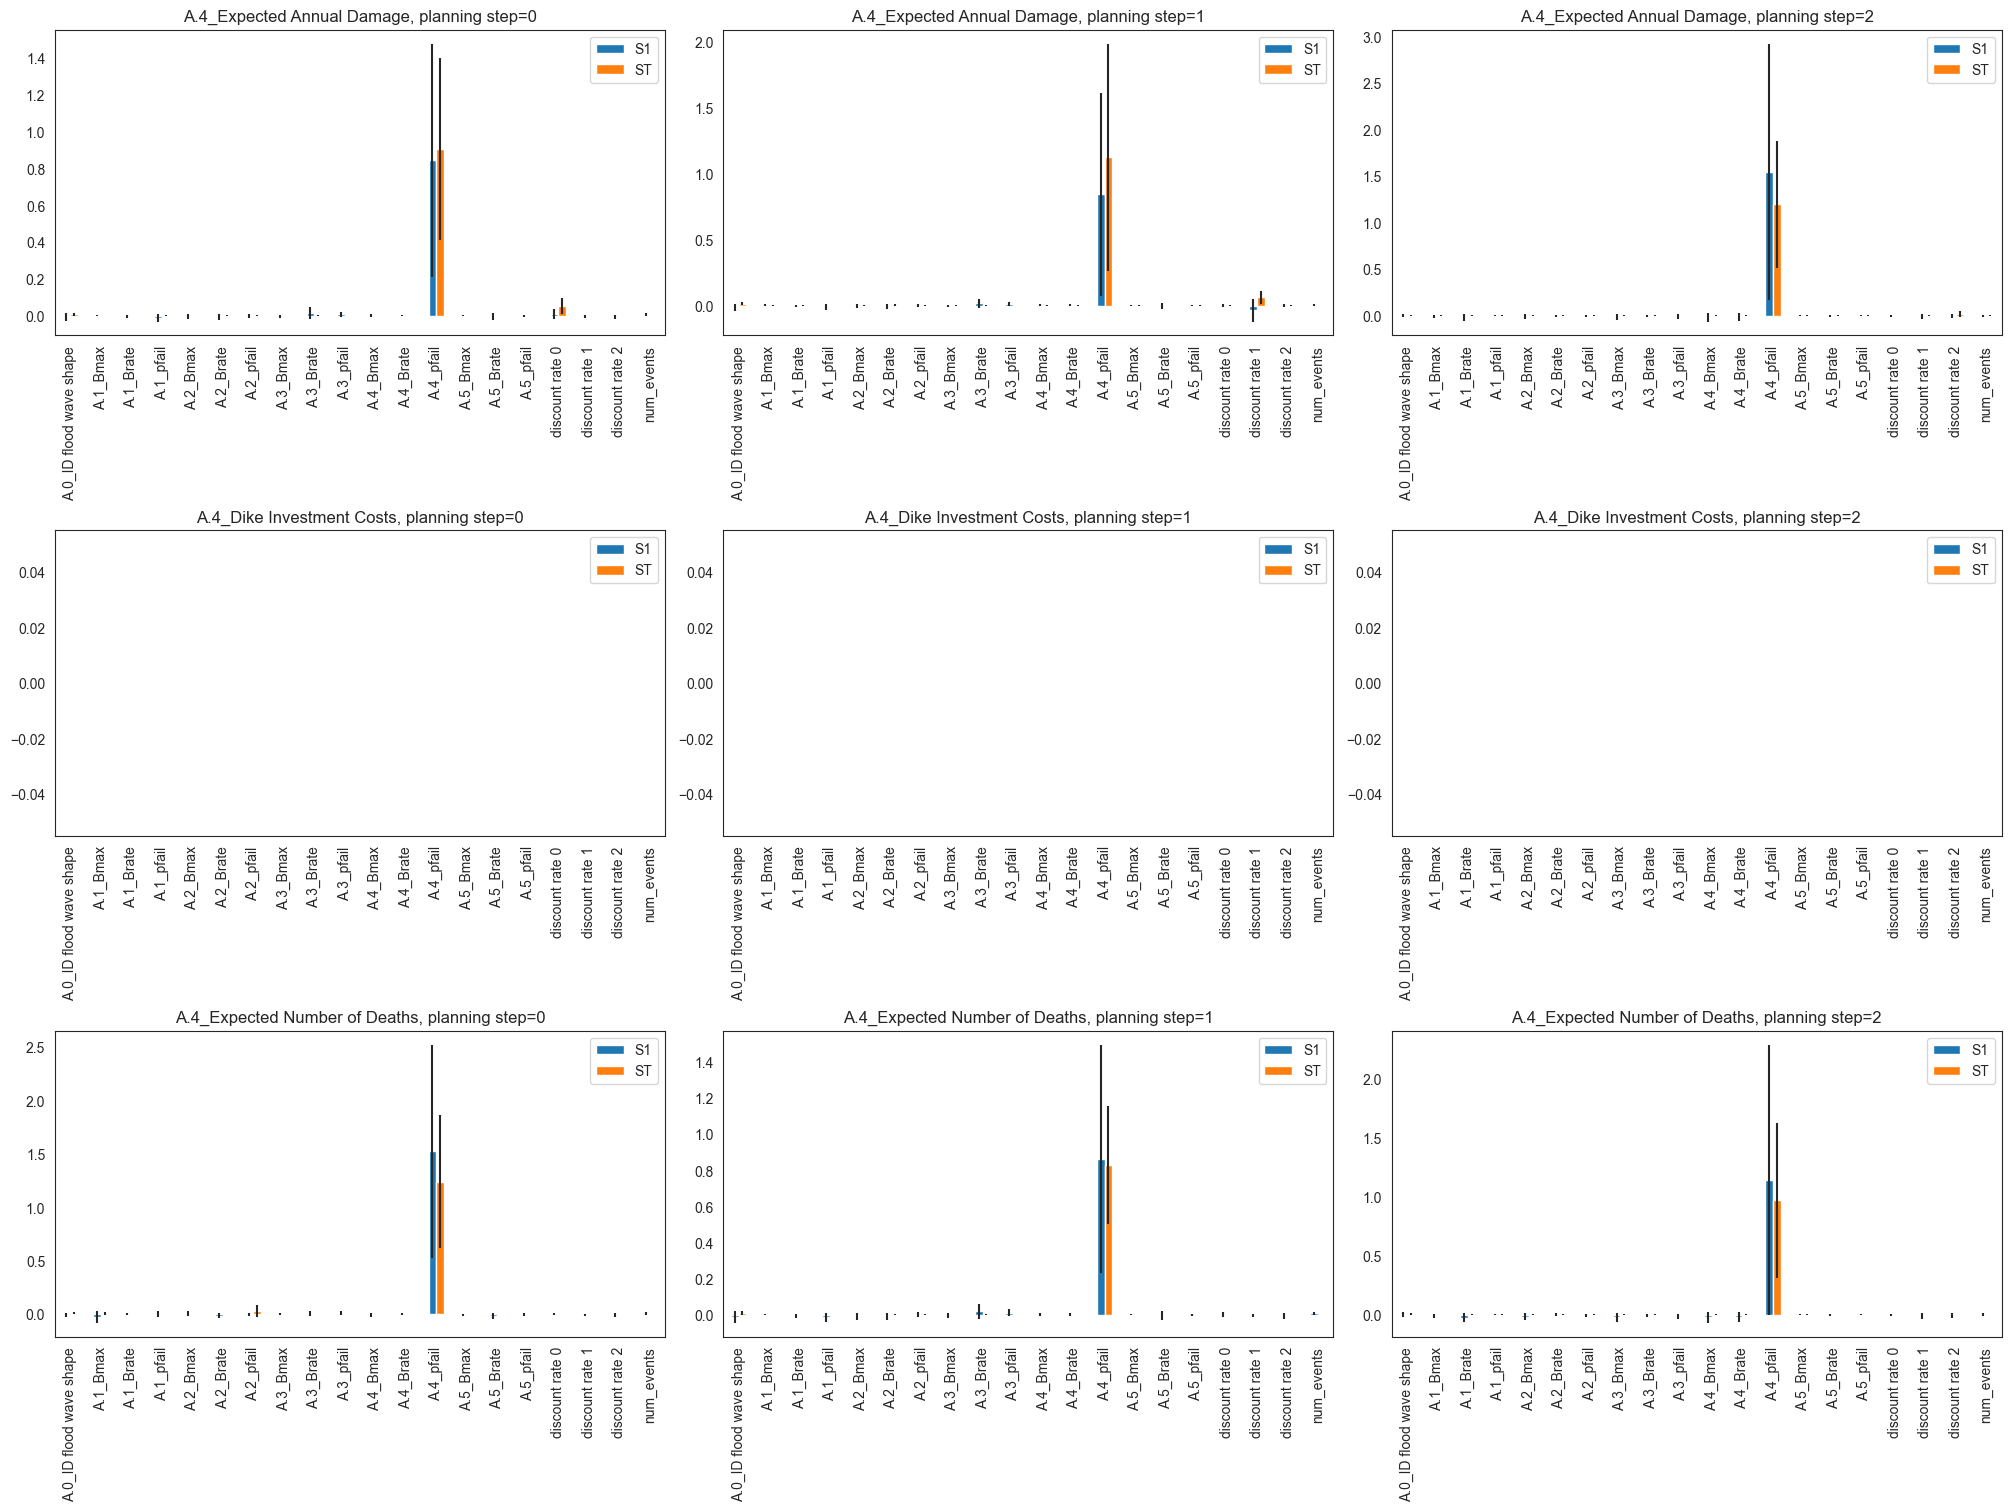

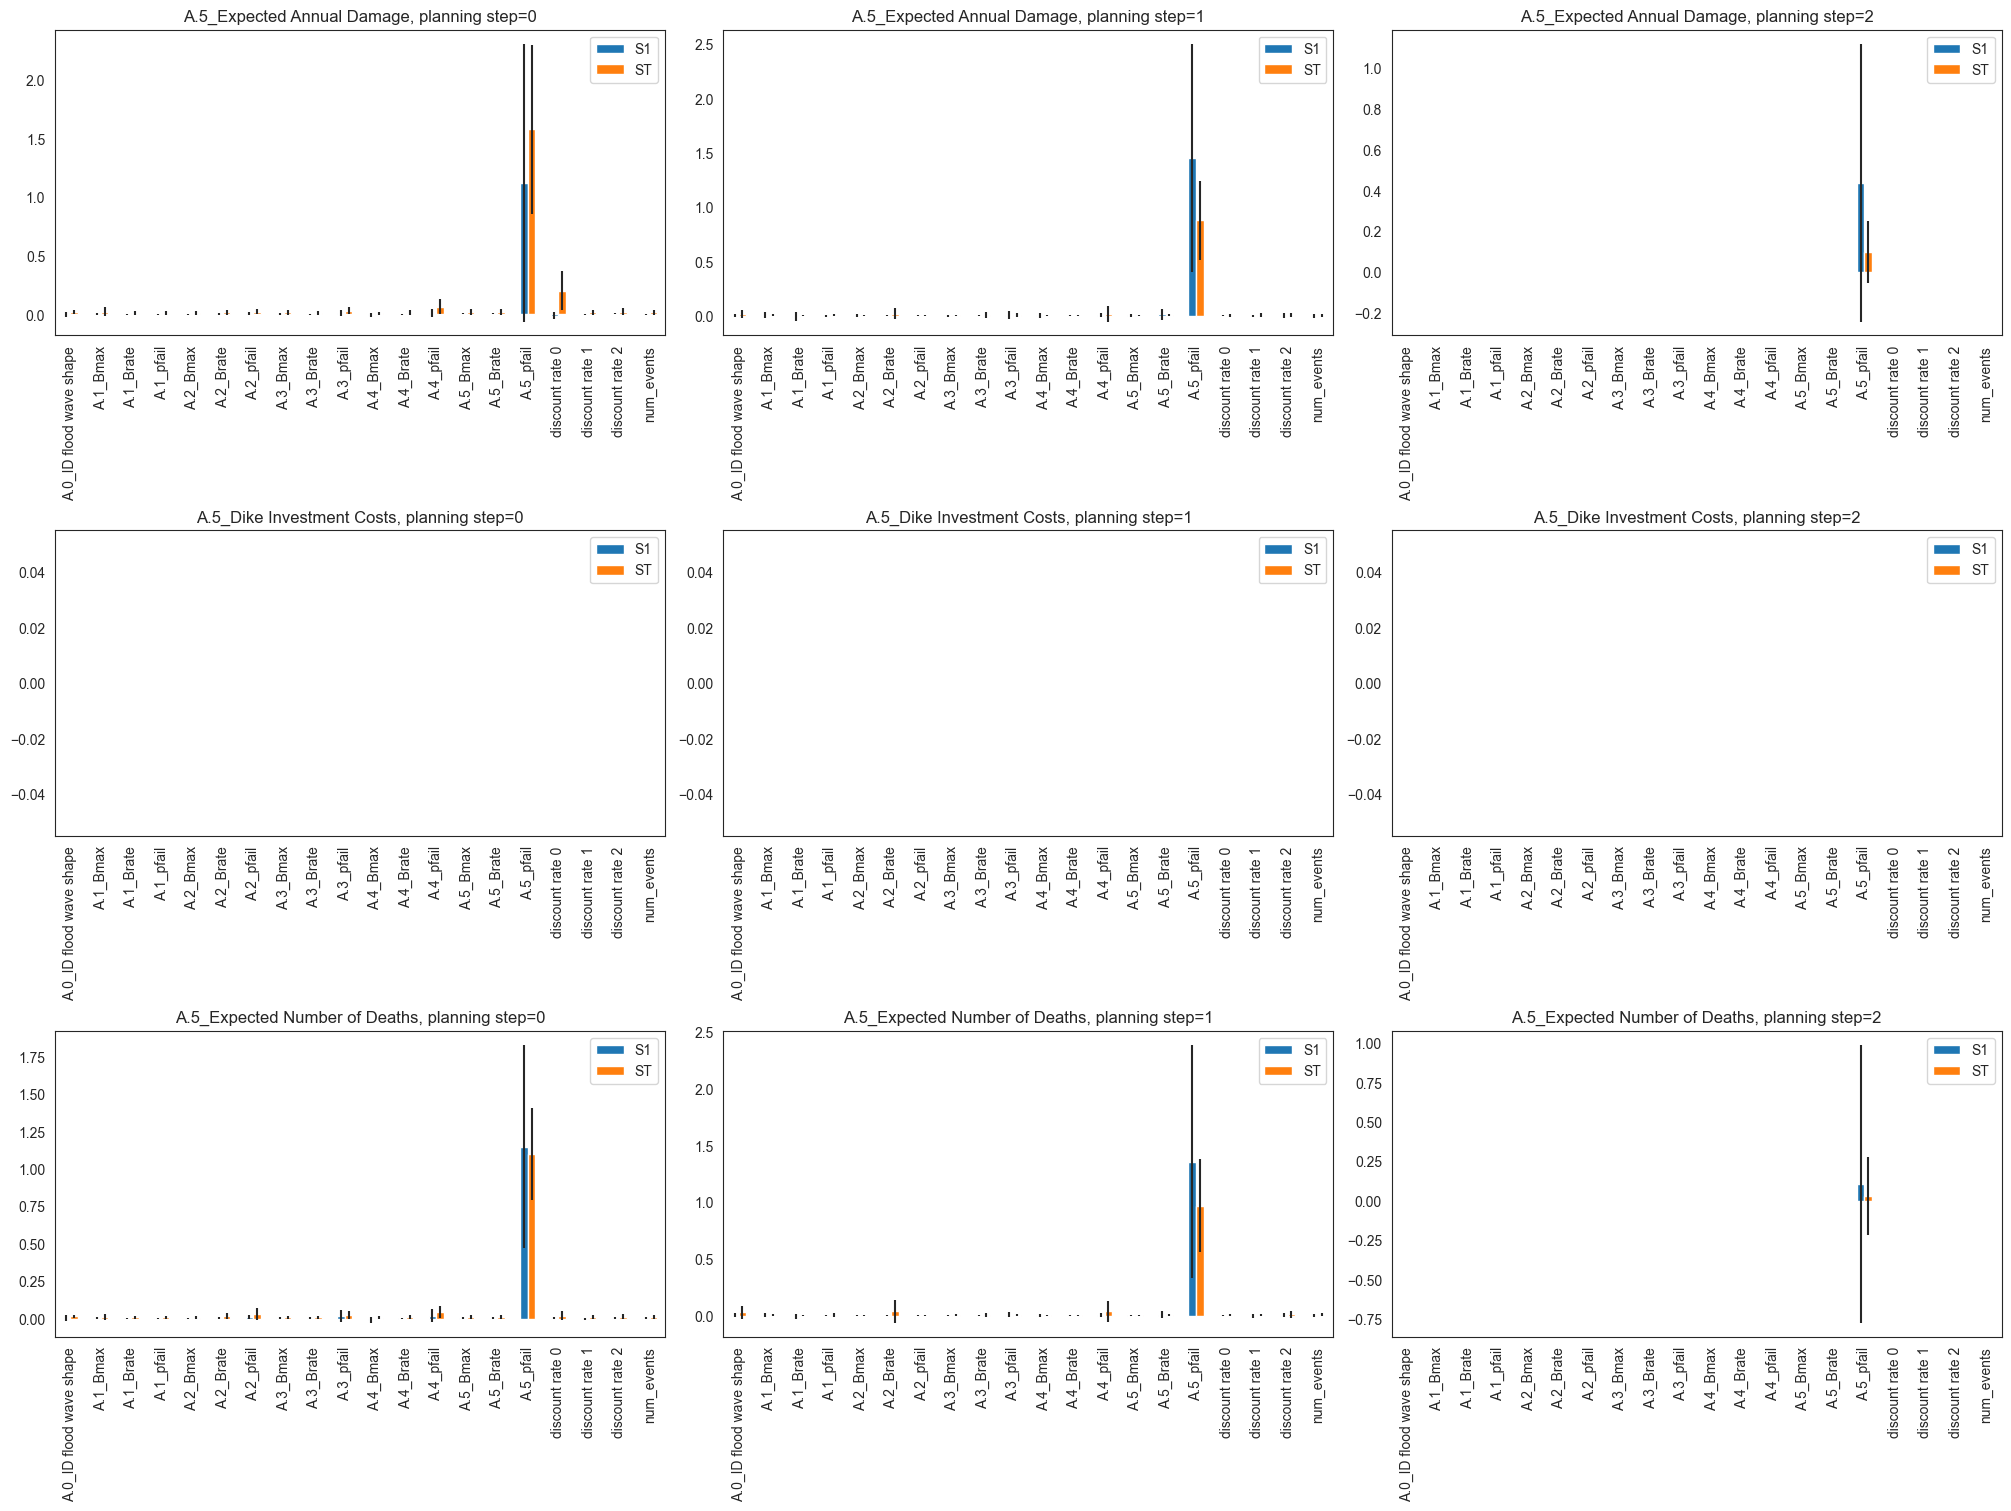

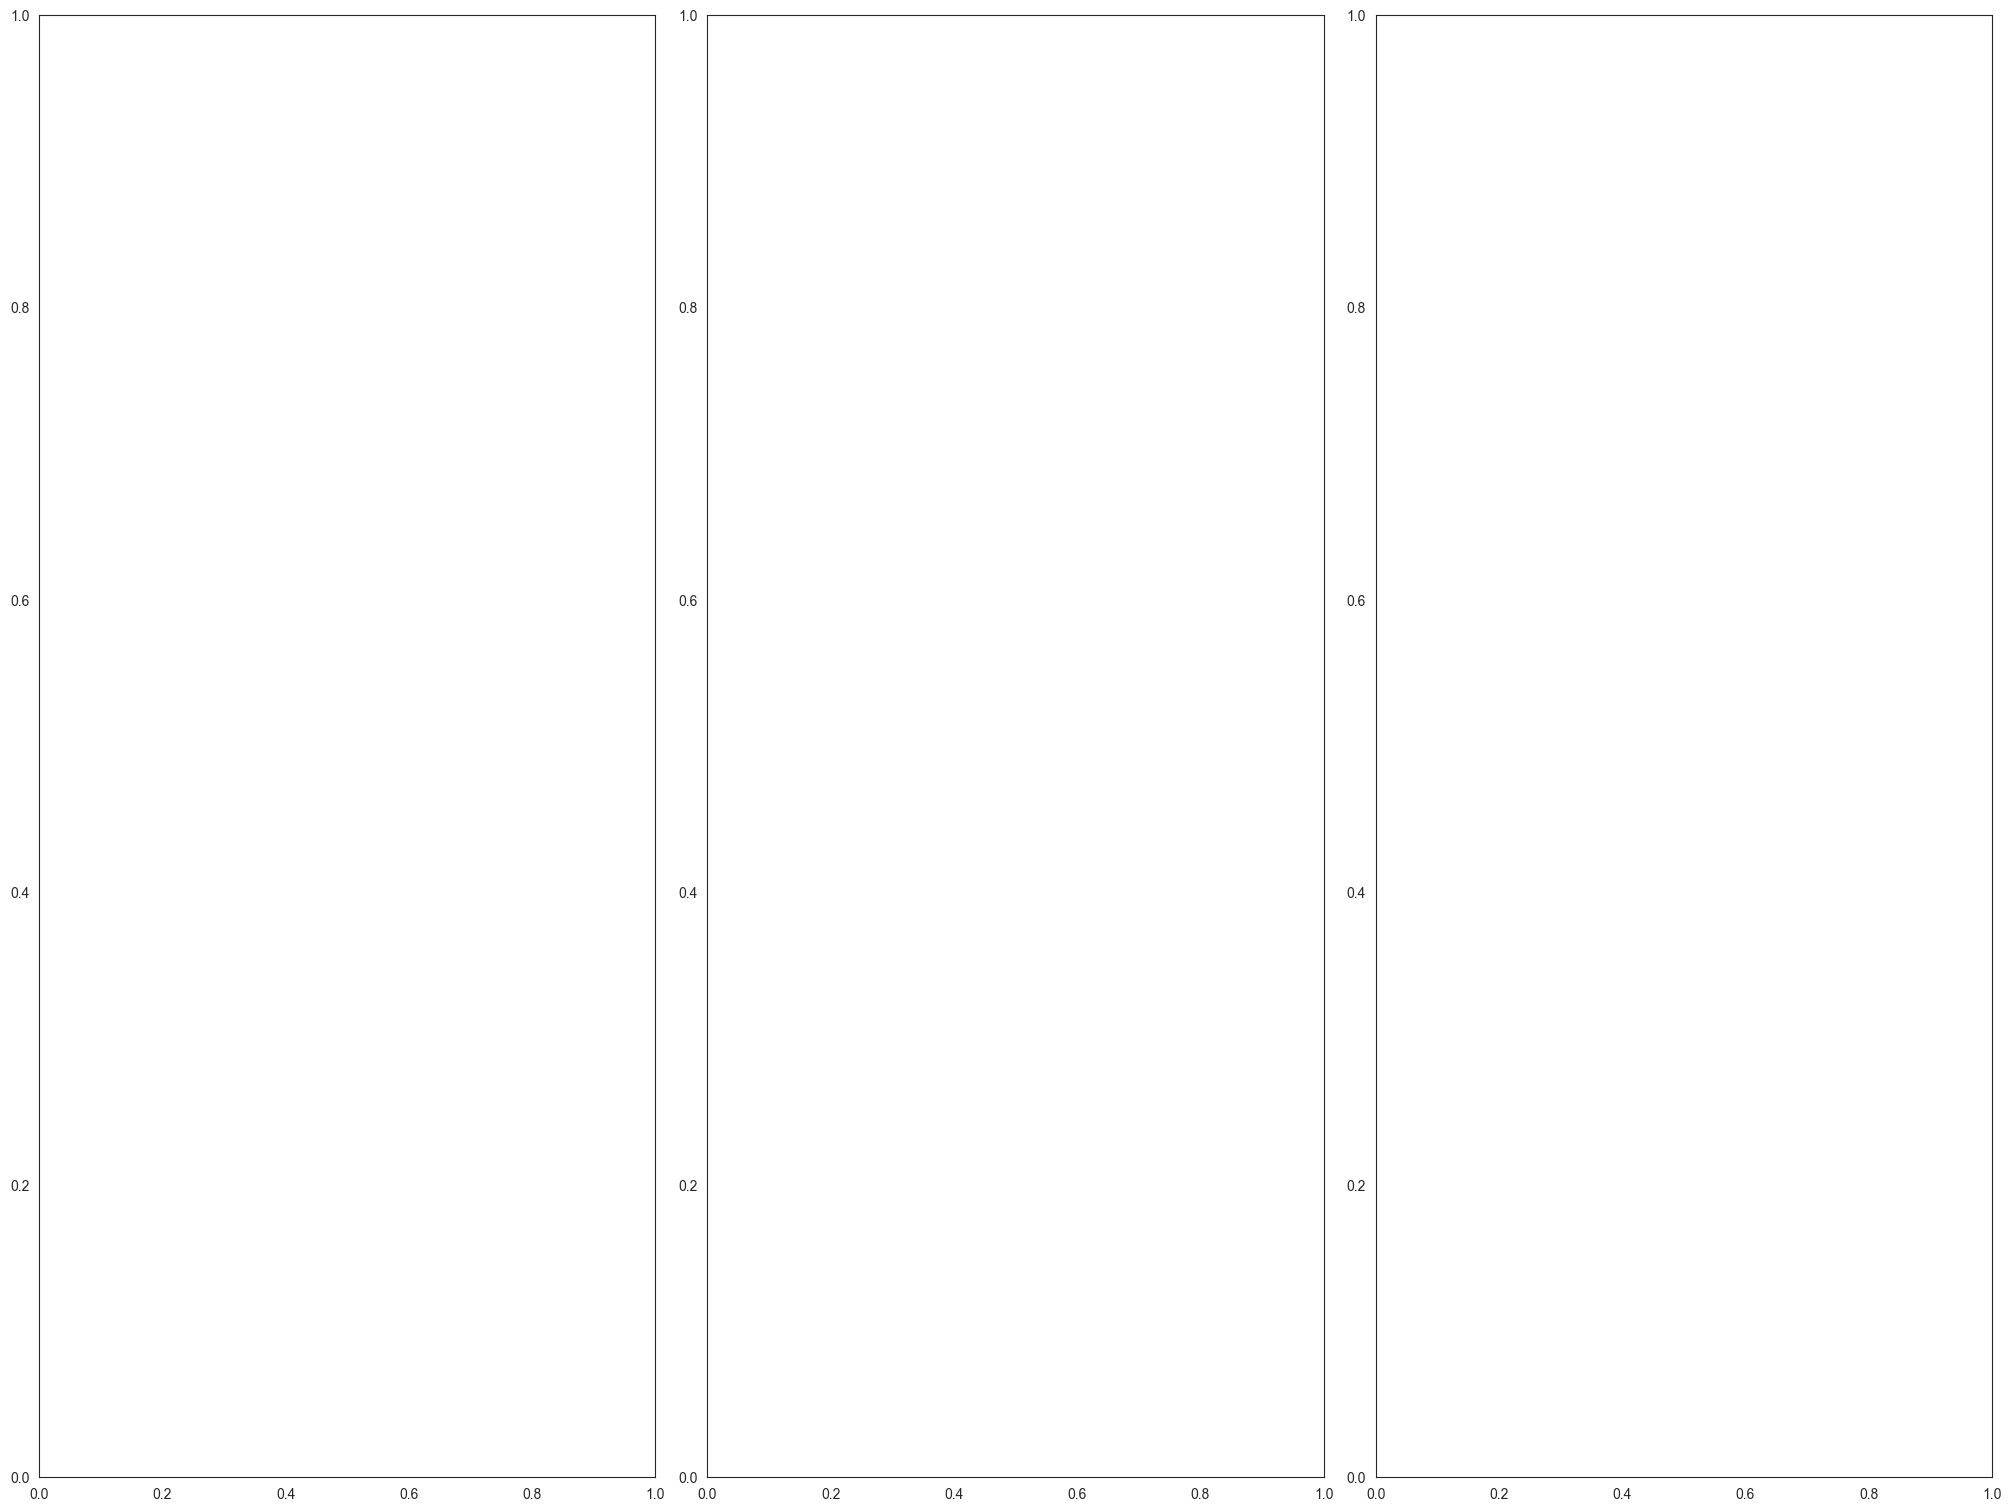

In [12]:
#fig, axes =plt.subplots(3,1,figsize=(8,10),constrained_layout=True)
#fig.tight_layout()
#i=0
#step=0
#dike='A.1'
#ooi='A.1_Expected Annual Damage'

sns.set_style('white')
for dike, info in sobol_data.items():
    num_ooi = len(info.keys())
    if (num_ooi):
        num_steps=3
        fig, axes =plt.subplots(num_ooi,num_steps,figsize=(20,15),constrained_layout=True)
        #axes.flatten()
        i=0
        for ooi,planning_step in info.items():
        #num_steps=len(planning_step.keys())
            for step,df in planning_step.items():
                indices = df[['S1','ST']]
                err =  df[['S1_conf','ST_conf']]
                indices.plot.bar(yerr=err.values.T,ax=axes[i][step],title=f"{ooi}, planning step={step}")
            i+=1
        fig.savefig(f"sobol_plots/planning_step={step}, category={dike}_4_policy_dataset.png")
        del fig

In [28]:
s2_data_conf['A.1']['A.1_Expected Annual Damage'][0]

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,num_events
A.0_ID flood wave shape,NaN,0.029403,0.029026,0.038344,0.029146,0.029398,0.029654,0.029192,0.029482,0.028959,0.029556,0.029075,0.029480,0.029615,0.029994,0.029338,0.028068,0.030021,0.029445,0.029360
A.1_Bmax,NaN,NaN,0.043560,0.054080,0.042580,0.042264,0.040753,0.043706,0.043913,0.040962,0.042737,0.041905,0.041504,0.040624,0.036057,0.043669,0.055028,0.039880,0.042310,0.038846
A.1_Brate,NaN,NaN,NaN,0.052388,0.030792,0.030718,0.030883,0.030511,0.030643,0.030369,0.030893,0.030253,0.030478,0.030887,0.031100,0.030517,0.028494,0.030605,0.030468,0.030490
A.1_pfail,NaN,NaN,NaN,NaN,0.168447,0.164046,0.164900,0.173976,0.172933,0.175259,0.177789,0.157061,0.164707,0.161555,0.172016,0.171696,0.266861,0.176531,0.149637,0.176470
A.2_Bmax,NaN,NaN,NaN,NaN,NaN,0.029352,0.028883,0.030017,0.030147,0.028664,0.029660,0.028850,0.029050,0.028806,0.027234,0.029878,0.033625,0.028257,0.029216,0.027938
A.2_Brate,NaN,NaN,NaN,NaN,NaN,NaN,0.027215,0.027236,0.027549,0.026837,0.027339,0.026381,0.027226,0.027024,0.026883,0.027322,0.027858,0.026981,0.027411,0.026113
A.2_pfail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031026,0.031295,0.030255,0.031229,0.029959,0.030965,0.030627,0.030352,0.031049,0.034281,0.030656,0.030943,0.029804
A.3_Bmax,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036449,0.033693,0.035101,0.034370,0.033883,0.032821,0.027844,0.036252,0.050248,0.031629,0.034682,0.030772
A.3_Brate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033515,0.033679,0.032823,0.033456,0.033513,0.033600,0.033445,0.032443,0.033202,0.033434,0.033157
A.3_pfail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028648,0.028132,0.028459,0.028702,0.028818,0.028574,0.026957,0.028494,0.028683,0.028201


<Axes: >

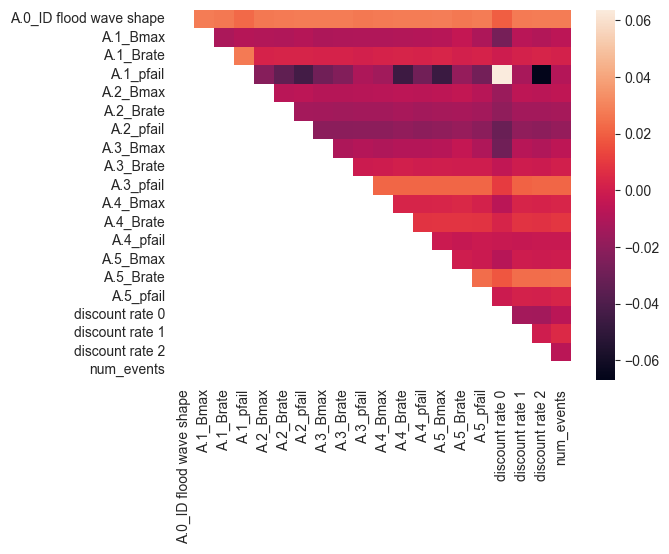

In [25]:
sns.heatmap(s2_data['A.1']['A.1_Expected Annual Damage'][0])

In [18]:
exp,_=results

In [19]:
problem=get_SALib_problem(dike_model.uncertainties)

In [21]:
#Y = results
ooi = 'A.1_Expected Annual Damage'
planning_step = 1
Y = outcomes[ooi][:,planning_step]
exp,_=results
n_exp = exp.shape[0]

s_data = pd.DataFrame(index=problem['names'],
                      columns=np.arange(20,n_exp,50)*(2*problem['num_vars']+2))
for j in s_data.columns:
    scores = sobol.analyze(problem, Y[0:j], calc_second_order=True, print_to_console=False)
    s_data.loc[:,j] = scores['ST']

C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


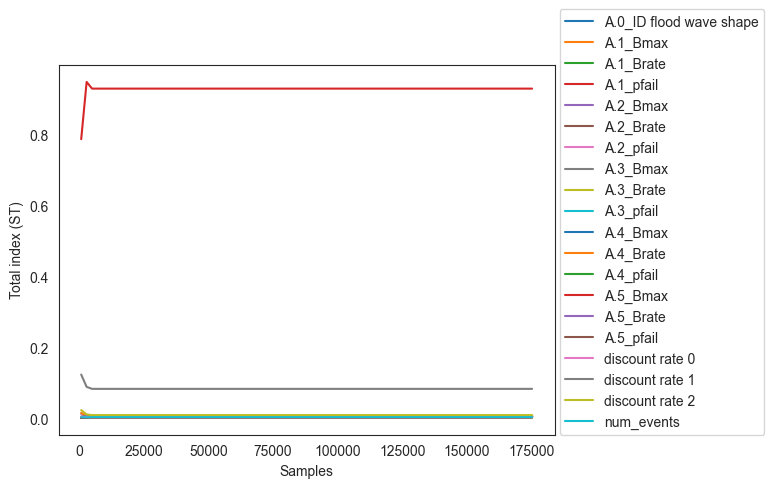

In [22]:
fig, ax = plt.subplots(1)

s_data.T.plot(ax=ax)
ax.set_xlabel('Samples')
ax.set_ylabel('Total index (ST)')
ax.legend(loc=(1.01,0))
plt.show()

### Analysing the Importance of different uncertainties under different policies

In [13]:
experiments.policy.unique()

[0, 1, 2, 3]
Categories (4, int64): [0, 1, 2, 3]

In [15]:
ooi='A.1_Expected Annual Damage'
planning_step=0
sobol_results = {}
problem = get_SALib_problem(dike_model.uncertainties)
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    y = outcomes[ooi][:,planning_step][logical]
    indices = sobol.analyze(problem, y)
    sobol_results[policy] = indices

C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\SALib\analyze\sobol.py:141: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


In [ ]:
axes[1]

C:\Users\gabby\miniconda3\envs\MBDM\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

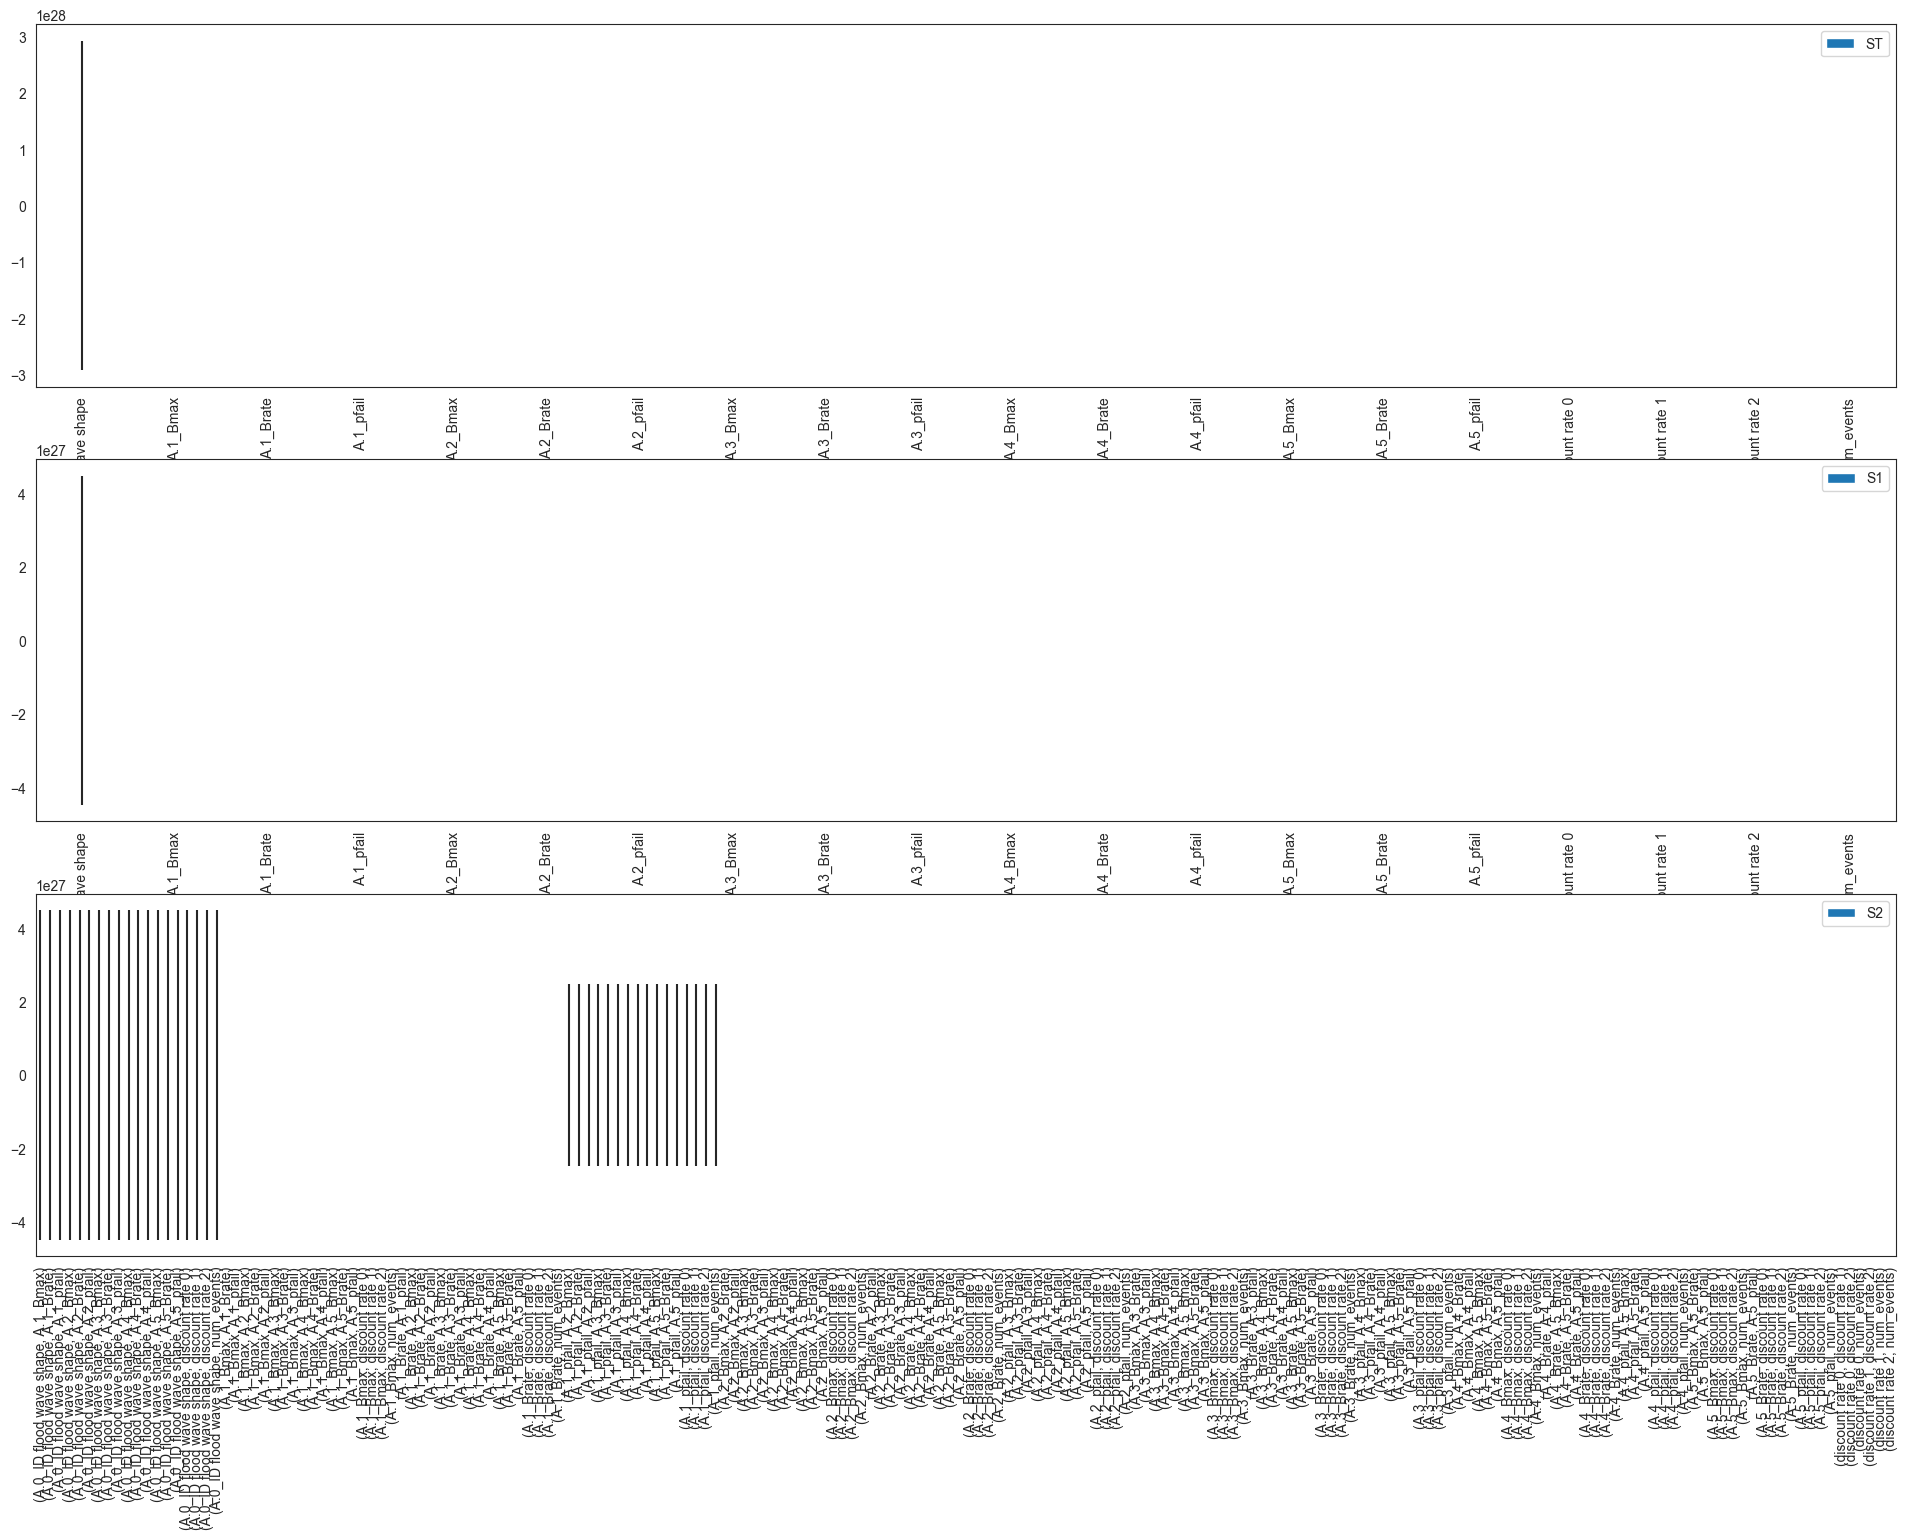

In [36]:
fig, axes = plt.subplots(3,1)
fig.set_size_inches(24, 16)
axes.flatten()
policy=1
sobol_results[policy].plot(ax=axes)

#i=0
#for policy in experiments.policy.unique():
#    print(policy)
    #sobol_results[policy].plot(ax = axes[i])
    #plt.title(f"{policy}")
    #i+=1

In [31]:
sobol_results[policy]['S1']


array([-6.00015215e-04, -5.23751788e-04, -6.97433581e-04,  9.39138464e-01,
       -3.39337789e-04,  3.91161427e-04, -3.29651007e-04,  3.93248486e-04,
        1.36934596e-05, -2.43509907e-03, -8.70512719e-04, -2.24169386e-06,
       -1.36119622e-03, -3.51501290e-04, -1.07772105e-03, -1.08659874e-03,
        2.14527750e-04,  1.87941014e-04, -2.35914663e-04,  4.26765897e-04])

In [35]:
df=sobol_results[policy]
indices = df['S1']
err =  df['S1_conf']
plt.bar(data=indices, yerr=err,title=f"{ooi}, planning step={step}")

TypeError: bar() missing 2 required positional arguments: 'x' and 'height'